In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Activation, BatchNormalization, Flatten, InputLayer, Input, GlobalAveragePooling2D, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.models import load_model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

from keras.preprocessing import image
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, average_precision_score, confusion_matrix, precision_recall_curve, auc
from keras import backend as K
from keras.layers.core import Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from itertools import combinations

Load the dataset

In [ ]:
def load_data():

      filenames1 = os.listdir('/content/drive/My Drive/CUHK02/P1/cam1/')
      filenames3 = os.listdir('/content/drive/My Drive/CUHK02/P2/cam1/')
      filenames5 = os.listdir('/content/drive/My Drive/CUHK02/P3/cam1/')
      filenames7 = os.listdir('/content/drive/My Drive/CUHK02/P4/cam1/')
      filenames9 = os.listdir('/content/drive/My Drive/CUHK02/P5/cam1/')
      filenames2 = os.listdir('/content/drive/My Drive/CUHK02/P1/cam2/')
      filenames4 = os.listdir('/content/drive/My Drive/CUHK02/P2/cam2/')
      filenames6 = os.listdir('/content/drive/My Drive/CUHK02/P3/cam2/')
      filenames8 = os.listdir('/content/drive/My Drive/CUHK02/P4/cam2/')
      filenames10 = os.listdir('/content/drive/My Drive/CUHK02/P5/cam2/')
      
      x = []
      labels = []
  
      for i in range(len(filenames1)):
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P1/cam1/'), filenames1[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames1[i][:3])]
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P1/cam2/'), filenames2[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames2[i][:3])]
        print(i)

      for i in range(len(labels)):
        if labels[i] > 134 and labels[i] < 628:
          labels[i] -= 1
        elif labels[i] > 628:
          labels[i] -= 2

      print('p1')

      for i in range(len(filenames3)):
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P2/cam1/'), filenames3[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames3[i][:3])+971]
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P2/cam2/'), filenames4[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames4[i][:3])+971]
        print(i)

      print('p2')
             
      for i in range(len(filenames5)):
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P3/cam1/'), filenames5[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames5[i][:3])+1277]
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P3/cam2/'), filenames6[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames6[i][:3])+1277]
        print(i)

      print('p3')

      for i in range(len(filenames7)):
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P4/cam1/'), filenames7[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames7[i][:3])+1385]
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P4/cam2/'), filenames8[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames8[i][:3])+1385]
        print(i)

      print('p4')
  
      for i in range(len(filenames9)):
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P5/cam1/'), filenames9[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames9[i][:3])+1578]
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK02/P5/cam2/'), filenames10[i]), cv2.IMREAD_UNCHANGED)]
        labels += [int(filenames10[i][:3])+1578]
        print(i)
      
      print('p5')
      
      for i in range(len(x)):
        x[i] = cv2.resize(x[i], (128,128), interpolation=cv2.INTER_LINEAR).astype('uint8')

      return x, labels

In [ ]:
x, labels = load_data()

idx = np.argsort(labels)
x = np.array(x)[idx]
labels = np.array(labels)[idx]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
pickle_out = open("/content/drive/My Drive/Data/CUHK02/x.pickle","wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/labels.pickle","wb")
pickle.dump(labels, pickle_out)
pickle_out.close()

In [2]:
pickle_in = open("/content/drive/My Drive/Data/CUHK02/x.pickle","rb")
x = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK02/labels.pickle","rb")
labels = pickle.load(pickle_in)

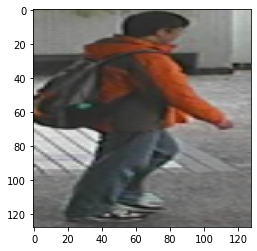

person 2


In [ ]:
plt.imshow(cv2.cvtColor(x[6], cv2.COLOR_BGR2RGB))
plt.show()
print('person', labels[6])

Train the MobileNet - Classification

In [ ]:
def base_model():

    mobilenet = keras.applications.mobilenet.MobileNet(input_shape=(128,128,3), weights="imagenet", include_top=False)

    model = Sequential()
    model.add(mobilenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1817, activation='softmax'))

    return model

In [ ]:
def train_valid_split(data,labels):
  
  x_train = []
  labels_train = []
  x_valid = []
  labels_valid = []

  for i in range(len(labels)):
    if i%4 == 0:
      x_valid += [data[i]]
      labels_valid += [labels[i]]
    else:
      x_train += [data[i]]
      labels_train += [labels[i]]

  x_train = np.array(x_train)
  labels_train = np.array(labels_train)
  x_valid = np.array(x_valid)
  labels_valid = np.array(labels_valid)

  return x_train, labels_train, x_valid, labels_valid


In [ ]:
labels = to_categorical(labels, num_classes=1817)

In [ ]:
x_train, labels_train, x_valid, labels_valid = train_valid_split(x,labels)

aux = np.arange(labels_train.shape[0])
np.random.shuffle(aux)
x_train = x_train[aux]
labels_train = labels_train[aux]

aux = np.arange(labels_valid.shape[0])
np.random.shuffle(aux)
x_valid = x_valid[aux]
labels_valid = labels_valid[aux]

In [ ]:
model = base_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1817)              1862425   
Total params: 7,190,489
Trainable params: 7,168,601
Non-trainable params: 21,888
_______________________________________

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

opt = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

callbacks = ModelCheckpoint('/content/drive/My Drive/Results/CUHK02/MobileNet_Class.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto')

results = model.fit(x_train, labels_train, batch_size=32, epochs=500, steps_per_epoch=50, callbacks = callbacks, validation_data=(x_valid, labels_valid))

Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 7.6471 - accuracy: 6.2500e-04
Epoch 00001: val_loss improved from inf to 7.55943, saving model to /content/drive/My Drive/Results/CUHK02/MobileNet_Class.h5
50/50 [==============================] - 4s 87ms/step - loss: 7.6471 - accuracy: 6.2500e-04 - val_loss: 7.5594 - val_accuracy: 5.5066e-04
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 7.6245 - accuracy: 0.0012
Epoch 00002: val_loss improved from 7.55943 to 7.52620, saving model to /content/drive/My Drive/Results/CUHK02/MobileNet_Class.h5
50/50 [==============================] - 4s 75ms/step - loss: 7.6245 - accuracy: 0.0012 - val_loss: 7.5262 - val_accuracy: 5.5066e-04
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 7.5938 - accuracy: 6.2500e-04
Epoch 00003: val_loss improved from 7.52620 to 7.50309, saving model to /content/drive/My Drive/Results/CUHK02/MobileNet_Class.h5
50/50 [==============================] - 4s 75ms/

In [ ]:
model = load_model('/content/drive/My Drive/Results/CUHK02/MobileNet_Class.h5')

predictions = []

for i in range(len(x_valid)):
  print(i)
  predictions.append(model.predict(np.expand_dims(x_valid[i], axis=0))[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
labels_valid = labels_valid.tolist()

for i in range(len(predictions)):
  predictions[i] = np.argmax(predictions[i])
  labels_valid[i] = np.array(labels_valid[i])
  labels_valid[i] = np.argmax(labels_valid[i])

predictions = np.array(predictions)
labels_valid = np.array(labels_valid)

In [ ]:
print('Accuracy: %.3f' % accuracy_score(labels_valid, predictions))
#print('Precision: %.3f' % precision_score(labels_valid, predictions, average='micro'))
#print('Recall: %.3f' % recall_score(labels_valid, predictions, average='micro'))
#print('AP: %.3f' % average_precision_score(labels_valid, predictions))
#confusion_matrix(labels_valid, predictions)

Accuracy: 0.514


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


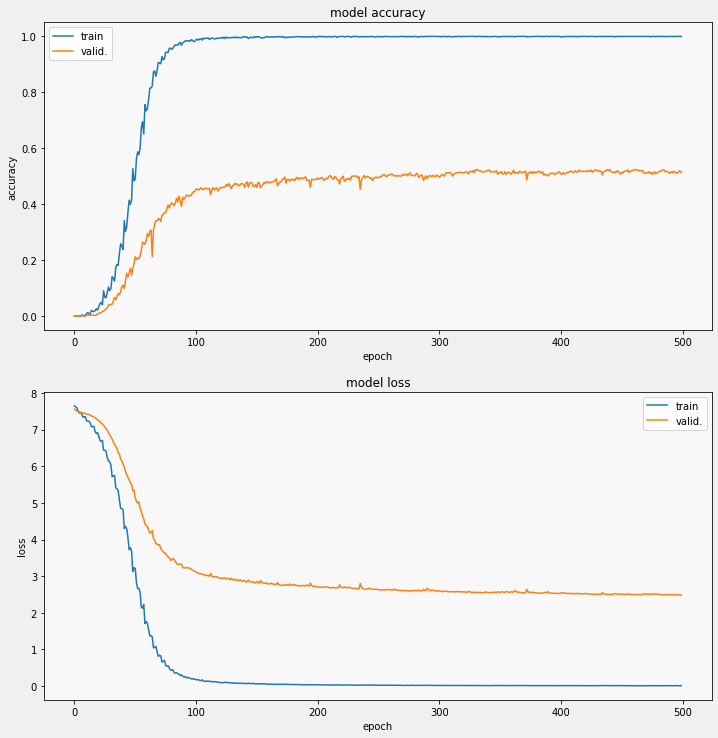

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])


print(results.history.keys())
display_training_curves(results.history['accuracy'], results.history['val_accuracy'], 'accuracy', 211)
display_training_curves(results.history['loss'], results.history['val_loss'], 'loss', 212)

-----------------RE-ID PART--------------------

In [35]:
def divide_data_reid_open(x,labels):

  data_train = []
  labels_train = []

  data_valid = []
  labels_valid = []

  for i in range(len(labels)):
    if labels[i] < 1270:
      data_train.append(x[i])
      labels_train.append(labels[i])
    else:
      data_valid.append(x[i])
      labels_valid.append(labels[i])

  data_train = np.array(data_train)
  data_valid = np.array(data_valid)
  labels_train = np.array(labels_train)
  labels_valid = np.array(labels_valid)

  return data_train, labels_train, data_valid, labels_valid

In [6]:
def divide_data_reid_close(x,labels):

  data_train = []
  labels_train = []

  data_valid = []
  labels_valid = []

  for i in range(len(labels)):
    if i%2 == 0:
      data_train.append(x[i])
      labels_train.append(labels[i])
    else:
      data_valid.append(x[i])
      labels_valid.append(labels[i])
    

  data_train = np.array(data_train)
  data_valid = np.array(data_valid)
  labels_train = np.array(labels_train)
  labels_valid = np.array(labels_valid)

  return data_train, labels_train, data_valid, labels_valid

In [ ]:
def l1_distance(inputs):
    input1, input2 = inputs
    #print(input1.shape, input2.shape)
    output = K.abs(input1 - input2)
    #print(output.shape)
    return output


def l1_distance_output_shape(shapes):
    shape1, shape2 = shapes
    assert shape1 == shape2
    return (1,)

In [ ]:
def get_mobile_net(x):

	model = load_model('/content/drive/My Drive/Results/CUHK02/MobileNet_Class.h5')
	new_model = Model(model.input, model.layers[-3].output)
	
	new_model.summary()
	
	feature_vectors = []
	i=0
	for xi in x:
		feature_vectors.append(new_model.predict(np.expand_dims(xi, axis=0)))
		i+=1
		print(i)
	
	for j in range(len(feature_vectors)):
		feature_vectors[j] = feature_vectors[j][0]
	
	feature_vectors = np.array(feature_vectors)

	return feature_vectors

In [ ]:
feat_vect = get_mobile_net(x)

In [ ]:
pickle_out = open("/content/drive/My Drive/Data/CUHK02/feat_vect.pickle","wb")
pickle.dump(feat_vect, pickle_out)
pickle_out.close()

In [3]:
pickle_in = open("/content/drive/My Drive/Data/CUHK02/feat_vect.pickle","rb")
feat_vect = pickle.load(pickle_in)

In [ ]:
def siamese_model():
   
    input1 = Input(shape=(2048,))
    dense_layer = Dense(1024, activation='relu')(input1)
    dense_layer = Dense(512, activation='relu')(dense_layer)
    dense_layer = Dense(256, activation='relu')(dense_layer)    
    dense_layer = Dense(10, activation='relu')(dense_layer)
    output = Dense(1, activation='sigmoid')(dense_layer)

    return Model(inputs=input1, outputs=output)

def siamese_model_1024():
   
    input1 = Input(shape=(1024,))
    input2 = Input(shape=(1024,))
    distance = Lambda(l1_distance, output_shape=l1_distance_output_shape)([input1, input2])    
    dense_layer = Dense(1024, activation='relu')(distance)
    dense_layer = Dense(1024, activation='relu')(dense_layer)
    dense_layer = Dense(512, activation='relu')(dense_layer)
    dense_layer = Dense(256, activation='relu')(dense_layer)
    dense_layer = Dense(10, activation='relu')(dense_layer)
    output = Dense(1, activation='sigmoid')(dense_layer)

    return Model(inputs=[input1, input2], outputs=output)

In [ ]:
def create_pairs_(x, labels):

    input1 = []
    input2 = []
    pair_labels = []
    image1 = []
    image2 = []

    for i in range(len(x)):
      for j in range(len(x)):
        if i != j:
          if labels[i] == labels[j]:
            label = 1
          else:
            label = 0

          input1 += [x[i]]
          input2 += [x[j]]
          pair_labels += [label]
          image1 += [labels[i]]
          image2 += [labels[j]]

    c = list(zip(input1, input2, pair_labels, image1, image2))

    random.shuffle(c)

    input1, input2, pair_labels, image1, image2 = zip(*c)

    #number of pairs labeled with 1
    count=0
    for label in pair_labels:
      if label == 1:
        count+=1

    final_input1 = []
    final_input2 = []
    final_pair_labels = []
    final_image1 = []
    final_image2 = []

    zero_count = 0

    for i in range(len(pair_labels)):
      if pair_labels[i] == 1:
        for j in range(14):
          final_input1.append(input1[i])
          final_input2.append(input2[i])
          final_pair_labels.append(pair_labels[i])
          final_image1.append(image1[i])
          final_image2.append(image2[i])
      elif pair_labels[i] == 0 and zero_count < 14*count:
        final_input1.append(input1[i])
        final_input2.append(input2[i])
        final_pair_labels.append(pair_labels[i])
        final_image1.append(image1[i])
        final_image2.append(image2[i])
        zero_count += 1
      #if len(final_pair_labels) == count*2:
       # break

    final_input1 = np.array(final_input1)
    final_input2 = np.array(final_input2)
    final_pair_labels = np.array(final_pair_labels)
    final_image1 = np.array(final_image1)
    final_image2 = np.array(final_image2)

    return final_input1, final_input2, final_pair_labels, final_image1, final_image2


def create_pairs_l(x, labels):

    input1 = []
    input2 = []
    pair_labels = []
    image1 = []
    image2 = []

    for i in range(len(x)):
      for j in range(len(x)):
        if i < j:
          if labels[i] == labels[j]:
            label = 1
          else:
            label = 0

          input1 += [x[i]]
          input2 += [x[j]]
          pair_labels += [label]
          image1 += [labels[i]]
          image2 += [labels[j]]

    c = list(zip(input1, input2, pair_labels, image1, image2))

    random.shuffle(c)

    input1, input2, pair_labels, image1, image2 = zip(*c)

    #number of pairs labeled with 1
    count=0
    for label in pair_labels:
      if label == 1:
        count+=1

    final_input1 = []
    final_input2 = []
    final_pair_labels = []
    final_image1 = []
    final_image2 = []

    zero_count = 0

    for i in range(len(pair_labels)):
      if pair_labels[i] == 1:
        for j in range(7):
          final_input1.append(input1[i])
          final_input2.append(input2[i])
          final_pair_labels.append(pair_labels[i])
          final_image1.append(image1[i])
          final_image2.append(image2[i])
      elif pair_labels[i] == 0 and zero_count < 7*count:
        final_input1.append(input1[i])
        final_input2.append(input2[i])
        final_pair_labels.append(pair_labels[i])
        final_image1.append(image1[i])
        final_image2.append(image2[i])
        zero_count += 1
      #if len(final_pair_labels) == count*2:
       # break

    final_input1 = np.array(final_input1)
    final_input2 = np.array(final_input2)
    final_pair_labels = np.array(final_pair_labels)
    final_image1 = np.array(final_image1)
    final_image2 = np.array(final_image2)

    return final_input1, final_input2, final_pair_labels, final_image1, final_image2

def create_pairs_h(x, labels):

    input1 = []
    input2 = []
    pair_labels = []
    image1 = []
    image2 = []

    for i in range(len(x)):
      for j in range(len(x)):
        if i > j:
          if labels[i] == labels[j]:
            label = 1
          else:
            label = 0

          input1 += [x[i]]
          input2 += [x[j]]
          pair_labels += [label]
          image1 += [labels[i]]
          image2 += [labels[j]]

    c = list(zip(input1, input2, pair_labels, image1, image2))

    random.shuffle(c)

    input1, input2, pair_labels, image1, image2 = zip(*c)

    #number of pairs labeled with 1
    count=0
    for label in pair_labels:
      if label == 1:
        count+=1

    final_input1 = []
    final_input2 = []
    final_pair_labels = []
    final_image1 = []
    final_image2 = []

    zero_count = 0

    for i in range(len(pair_labels)):
      if pair_labels[i] == 1:
        for j in range(6):
          final_input1.append(input1[i])
          final_input2.append(input2[i])
          final_pair_labels.append(pair_labels[i])
          final_image1.append(image1[i])
          final_image2.append(image2[i])
      elif pair_labels[i] == 0 and zero_count < 6*count:
        final_input1.append(input1[i])
        final_input2.append(input2[i])
        final_pair_labels.append(pair_labels[i])
        final_image1.append(image1[i])
        final_image2.append(image2[i])
        zero_count += 1
      #if len(final_pair_labels) == count*2:
       # break

    final_input1 = np.array(final_input1)
    final_input2 = np.array(final_input2)
    final_pair_labels = np.array(final_pair_labels)
    final_image1 = np.array(final_image1)
    final_image2 = np.array(final_image2)

    return final_input1, final_input2, final_pair_labels, final_image1, final_image2

In [36]:
data_train, labels_train, data_valid, labels_valid = divide_data_reid_open(feat_vect,labels)


In [ ]:
i1_train = np.concatenate((i1_train, i1_train_), axis=0)
i2_train = np.concatenate((i2_train, i2_train_), axis=0)
pair_labels_train = np.concatenate((pair_labels_train, pair_labels_train_), axis=0)
image1_t = np.concatenate((image1_t, image1_t_), axis=0)
image2_t = np.concatenate((image2_t, image2_t_), axis=0)


In [ ]:
for i in range(1200, 1817):
  c=0
  for j in image1_v:
    if i == j:
      c += 1
  print('P: ', i, 'N: ', c)

NameError: ignored

In [ ]:
i1_valid, i2_valid, pair_labels_valid, image1_v, image2_v = create_pairs_(data_valid, labels_valid)


In [ ]:
aux = np.arange(pair_labels_train.shape[0])
np.random.shuffle(aux)
i1_train = i1_train[aux]
i2_train = i2_train[aux]
pair_labels_train = pair_labels_train[aux]

aux = np.arange(pair_labels_valid.shape[0])
np.random.shuffle(aux)
i1_valid = i1_valid[aux]
i2_valid = i2_valid[aux]
pair_labels_valid = pair_labels_valid[aux]

In [ ]:
i_train = []
i_valid = []

for i in range(len(i1_train)):
  i_train.append(np.concatenate((i1_train[i], i2_train[i]), axis=None))

for i in range(len(i1_valid)):
  i_valid.append(np.concatenate((i1_valid[i], i2_valid[i]), axis=None))

i_train = np.array(i_train)
i_valid = np.array(i_valid)

In [ ]:
# CREATE DATA FOR OPEN WORLD
data_train, labels_train, data_valid, labels_valid = divide_data_reid_open(feat_vect,labels)

i1_train, i2_train, pair_labels_train = create_pairs_(data_train, labels_train)
i1_valid, i2_valid, pair_labels_valid = create_pairs_(data_valid, labels_valid)

aux = np.arange(pair_labels_train.shape[0])
np.random.shuffle(aux)
i1_train = i1_train[aux]
i2_train = i2_train[aux]
pair_labels_train = pair_labels_train[aux]

aux = np.arange(pair_labels_valid.shape[0])
np.random.shuffle(aux)
i1_valid = i1_valid[aux]
i2_valid = i2_valid[aux]
pair_labels_valid = pair_labels_valid[aux]

i_train = []
i_valid = []

for i in range(len(i1_train)):
  i_train.append(np.concatenate((i1_train[i], i2_train[i]), axis=None))

for i in range(len(i1_valid)):
  i_valid.append(np.concatenate((i1_valid[i], i2_valid[i]), axis=None))

i_train = np.array(i_train)
i_valid = np.array(i_valid)

In [ ]:
# SAVE TRAIN AND VALID FOR OPEN-WORLD
pickle_out = open("/content/drive/My Drive/Data/CUHK02/i_train_open.pickle","wb")
pickle.dump(i_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/pair_labels_train_open.pickle","wb")
pickle.dump(pair_labels_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i1_train_open.pickle","wb")
pickle.dump(i1_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i2_train_open.pickle","wb")
pickle.dump(i2_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i_valid_open.pickle","wb")
pickle.dump(i_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/pair_labels_valid_open.pickle","wb")
pickle.dump(pair_labels_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i1_valid_open.pickle","wb")
pickle.dump(i1_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i2_valid_open.pickle","wb")
pickle.dump(i2_valid, pickle_out)
pickle_out.close()

In [ ]:
# GET DATA FOR OPEN WORLD

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i_train_open.pickle","rb")
i_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK02/pair_labels_train_open.pickle","rb")
pair_labels_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i1_train_open.pickle","rb")
i1_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i2_train_open.pickle","rb")
i2_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i_valid_open.pickle","rb")
i_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK02/pair_labels_valid_open.pickle","rb")
pair_labels_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i1_valid_open.pickle","rb")
i1_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i2_valid_open.pickle","rb")
i2_valid = pickle.load(pickle_in)

In [7]:
data_train, labels_train, data_valid, labels_valid = divide_data_reid_close(feat_vect,labels)


In [ ]:
# CREATE DATA FOR CLOSE WORLD
data_train, labels_train, data_valid, labels_valid = divide_data_reid_close(feat_vect,labels)

i1_train, i2_train, pair_labels_train, image1_t, image2_t = create_pairs_(data_train, labels_train)
i1_valid, i2_valid, pair_labels_valid, image1_v, image2_v = create_pairs_(data_valid, labels_valid)

aux = np.arange(pair_labels_train.shape[0])
np.random.shuffle(aux)
i1_train = i1_train[aux]
i2_train = i2_train[aux]
pair_labels_train = pair_labels_train[aux]

aux = np.arange(pair_labels_valid.shape[0])
np.random.shuffle(aux)
i1_valid = i1_valid[aux]
i2_valid = i2_valid[aux]
pair_labels_valid = pair_labels_valid[aux]

i_train = []
i_valid = []

for i in range(len(i1_train)):
  i_train.append(np.concatenate((i1_train[i], i2_train[i]), axis=None))

for i in range(len(i1_valid)):
  i_valid.append(np.concatenate((i1_valid[i], i2_valid[i]), axis=None))

i_train = np.array(i_train)
i_valid = np.array(i_valid)

In [ ]:
# SAVE TRAIN AND VALID FOR CLOSE-WORLD

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i_train_close.pickle","wb")
pickle.dump(i_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/pair_labels_train_close.pickle","wb")
pickle.dump(pair_labels_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i1_train_close.pickle","wb")
pickle.dump(i1_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i2_train_close.pickle","wb")
pickle.dump(i2_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i_valid_close.pickle","wb")
pickle.dump(i_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/pair_labels_valid_close.pickle","wb")
pickle.dump(pair_labels_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i1_valid_close.pickle","wb")
pickle.dump(i1_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK02/i2_valid_close.pickle","wb")
pickle.dump(i2_valid, pickle_out)
pickle_out.close()

In [ ]:
# GET DATA FOR CLOSE WORLD

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i_train_close.pickle","rb")
i_train = pickle.load(pickle_in)

print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK02/pair_labels_train_close.pickle","rb")
pair_labels_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i1_train_close.pickle","rb")
i1_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i2_train_close.pickle","rb")
i2_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i_valid_close.pickle","rb")
i_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK02/pair_labels_valid_close.pickle","rb")
pair_labels_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i1_valid_close.pickle","rb")
i1_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK02/i2_valid_close.pickle","rb")
i2_valid = pickle.load(pickle_in)

In [ ]:
i_train = i_train[:3632]
i1_train = i1_train[:3632]
i2_train = i2_train[:3632]
pair_labels_train = pair_labels_train[:3632]

i_valid = i_valid[:3632]
i1_valid = i1_valid[:3632]
i2_valid = i2_valid[:3632]
pair_labels_valid = pair_labels_valid[:3632]

In [ ]:
model = siamese_model_1024()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=10000,
    decay_rate=0.9)

opt = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1024)         1049600     lambda[0][0]          

In [ ]:
callbacks = ModelCheckpoint('/content/drive/My Drive/Results/CUHK02/open_reid_1024_final.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto')

In [ ]:
#2048 input
#reid_results = model.fit(i_train, pair_labels_train, batch_size=32, steps_per_epoch=20, epochs=200, verbose=2, validation_data=(i_valid, pair_labels_valid), callbacks=callbacks)

#1024 input
reid_results = model.fit([i1_train, i2_train], pair_labels_train, batch_size=32, steps_per_epoch=20, epochs=200, verbose=2, validation_data=([i1_valid, i2_valid], pair_labels_valid), callbacks=callbacks)

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.68535, saving model to /content/drive/My Drive/Results/CUHK02/open_reid_1024_final.h5
20/20 - 44s - loss: 0.6756 - accuracy: 0.5188 - val_loss: 0.6854 - val_accuracy: 0.5047
Epoch 2/200

Epoch 00002: val_loss improved from 0.68535 to 0.67673, saving model to /content/drive/My Drive/Results/CUHK02/open_reid_1024_final.h5
20/20 - 43s - loss: 0.6641 - accuracy: 0.5000 - val_loss: 0.6767 - val_accuracy: 0.5422
Epoch 3/200

Epoch 00003: val_loss improved from 0.67673 to 0.66731, saving model to /content/drive/My Drive/Results/CUHK02/open_reid_1024_final.h5
20/20 - 42s - loss: 0.6394 - accuracy: 0.5672 - val_loss: 0.6673 - val_accuracy: 0.5654
Epoch 4/200

Epoch 00004: val_loss improved from 0.66731 to 0.66150, saving model to /content/drive/My Drive/Results/CUHK02/open_reid_1024_final.h5
20/20 - 42s - loss: 0.6425 - accuracy: 0.5734 - val_loss: 0.6615 - val_accuracy: 0.5983
Epoch 5/200

Epoch 00005: val_loss improved from 0.66150 to 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


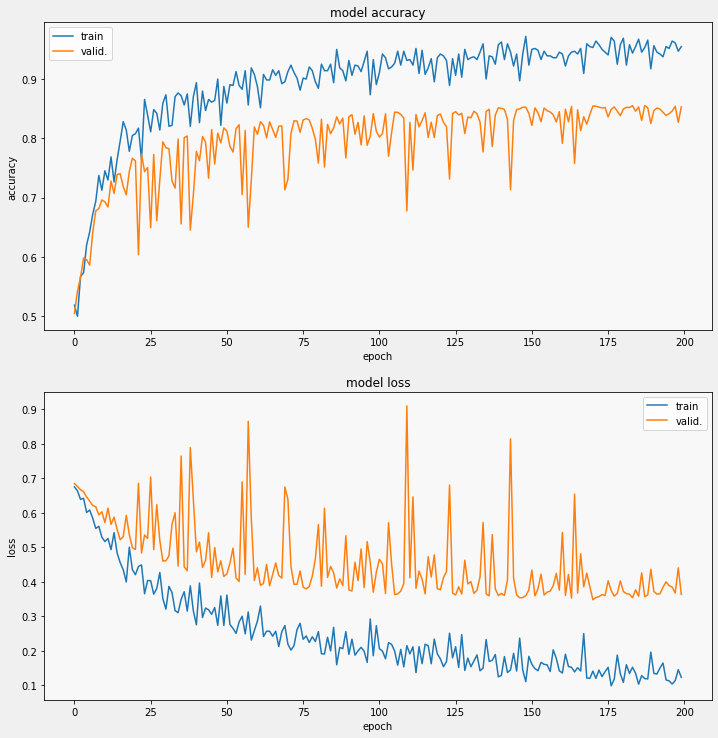

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])


print(reid_results.history.keys())
display_training_curves(reid_results.history['accuracy'], reid_results.history['val_accuracy'], 'accuracy', 211)
display_training_curves(reid_results.history['loss'], reid_results.history['val_loss'], 'loss', 212)

Streaming output truncated to the last 5000 lines.
178792
178793
178794
178795
178796
178797
178798
178799
178800
178801
178802
178803
178804
178805
178806
178807
178808
178809
178810
178811
178812
178813
178814
178815
178816
178817
178818
178819
178820
178821
178822
178823
178824
178825
178826
178827
178828
178829
178830
178831
178832
178833
178834
178835
178836
178837
178838
178839
178840
178841
178842
178843
178844
178845
178846
178847
178848
178849
178850
178851
178852
178853
178854
178855
178856
178857
178858
178859
178860
178861
178862
178863
178864
178865
178866
178867
178868
178869
178870
178871
178872
178873
178874
178875
178876
178877
178878
178879
178880
178881
178882
178883
178884
178885
178886
178887
178888
178889
178890
178891
178892
178893
178894
178895
178896
178897
178898
178899
178900
178901
178902
178903
178904
178905
178906
178907
178908
178909
178910
178911
178912
178913
178914
178915
178916
178917
178918
178919
178920
178921
178922
178923
178924
178925
178926
1789

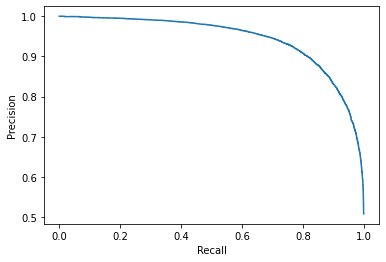

mAP: 0.9438
Accuracy: 0.865
Precision: 0.869
Recall: 0.861
AP: 0.818


array([[79952, 11944],
       [12782, 79114]])

In [ ]:
### mAP Precision vs Recall 2048 ###

model = load_model('/content/drive/My Drive/Results/CUHK02/open_reid_2048_final.h5')

labels_pred = []

for i in range(len(i_valid)):
  print(i)
  labels_pred.append(model.predict(np.expand_dims(i_valid[i], axis=0))[0][0])

labels_pred = np.array(labels_pred)

precision, recall, thresholds = precision_recall_curve(pair_labels_valid, labels_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

print('mAP: %.4f' % auc(recall, precision))

for i in range(len(labels_pred)):
  if labels_pred[i] < 0.5:
    labels_pred[i] = 0
  else:
    labels_pred[i] = 1

labels_pred = np.array(labels_pred)

print('Accuracy: %.3f' % accuracy_score(pair_labels_valid, labels_pred))
print('Precision: %.3f' % precision_score(pair_labels_valid, labels_pred))
print('Recall: %.3f' % recall_score(pair_labels_valid, labels_pred))
print('AP: %.3f' % average_precision_score(pair_labels_valid, labels_pred))
confusion_matrix(pair_labels_valid, labels_pred)

0.9286419625129421


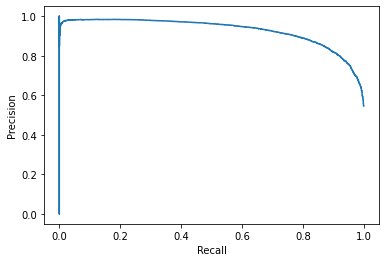

Accuracy: 0.854
Precision: 0.879
Recall: 0.822


array([[81495, 10401],
       [16352, 75544]])

In [ ]:
### mAP Precision vs Recall 1024 ###

model = load_model('/content/drive/My Drive/Results/CUHK02/open_reid_1024_final.h5')

cena1 = np.expand_dims(i1_valid, axis=0)
cena2 = np.expand_dims(i2_valid, axis=0)

labels_pred = model.predict([cena1, cena2])[0]

labels_pred = labels_pred.tolist()

for i in range(len(labels_pred)):
  labels_pred[i] = labels_pred[i][0]
    
labels_pred = np.array(labels_pred)

precision, recall, thresholds = precision_recall_curve(pair_labels_valid, labels_pred)

print(auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

for i in range(len(labels_pred)):
  if labels_pred[i] < 0.5:
    labels_pred[i] = 0
  else:
    labels_pred[i] = 1

labels_pred = np.array(labels_pred)

print('Accuracy: %.3f' % accuracy_score(pair_labels_valid, labels_pred))
print('Precision: %.3f' % precision_score(pair_labels_valid, labels_pred))
print('Recall: %.3f' % recall_score(pair_labels_valid, labels_pred))
confusion_matrix(pair_labels_valid, labels_pred)

In [39]:
query_list = []
gallery_list = []

x_classes = []
labels_classes = []

for j in range(1, 1817):
  aux_x = []
  aux_labels = []
  for i in range(len(labels)):
    if labels[i] == j:
      aux_x.append(feat_vect[i])
      aux_labels.append(labels[i])
  x_classes.append(aux_x)
  labels_classes.append(aux_labels)

for i in range(1816):
  rand = random.randint(0,3)
  gallery_list.append([labels_classes[i][rand], x_classes[i][rand]])

randomlist = random.sample(range(0, 1816), 100)
for i in randomlist:
  rand = random.randint(0,3)
  query_list.append([labels_classes[i][rand], x_classes[i][rand]])

In [10]:
def cmc_curve_2048(querys, gallery, topk):
    aux = 0
    ret = np.zeros(topk)
    valid_queries = 0
    all_rank = []
    sum_rank = np.zeros(topk)
    for query in querys:
        aux += 1
        print(aux)
        q_id = query[0]
        q_feature = query[1]
        # Calculate the distances for each query
        distmat = []
        for label, feature in gallery:
            #dist = np.linalg.norm(q_feature - feature)
            dist = model.predict(np.expand_dims(np.concatenate((q_feature, feature), axis=0), axis=0))
            distmat.append([dist, label])

        # Sort the results for each query
        distmat.sort(reverse=True)
        # Find matches
        matches = np.zeros(len(distmat))
        # Zero if no match 1 if match
        for i in range(0, len(distmat)):
            if distmat[i][1] == q_id:
                # Match found
                matches[i] = 1
        rank = np.zeros(topk)
        for i in range(0, topk):
            if matches[i] == 1:
                rank[i] = 1
                # If 1 is found then break as you dont need to look further path k
                break
        all_rank.append(rank)
        valid_queries +=1
    #print(all_rank)
    sum_all_ranks = np.zeros(len(all_rank[0]))
    for i in range(0,len(all_rank)):
        my_array = all_rank[i]
        for g in range(0, len(my_array)):
            sum_all_ranks[g] = sum_all_ranks[g] + my_array[g]
    sum_all_ranks = np.array(sum_all_ranks)
    print("NPSAR", sum_all_ranks)
    cmc_restuls = np.cumsum(sum_all_ranks) / valid_queries
    print(cmc_restuls)
    return cmc_restuls, sum_all_ranks


def cmc_curve_1024(querys, gallery, topk):
    aux = 0
    ret = np.zeros(topk)
    valid_queries = 0
    all_rank = []
    sum_rank = np.zeros(topk)
    for query in querys:
        aux += 1
        print(aux)
        q_id = query[0]
        q_feature = query[1]
        # Calculate the distances for each query
        distmat = []
        for label, feature in gallery:
            #dist = np.linalg.norm(q_feature - feature)
            dist = model.predict([np.expand_dims(q_feature, axis=0), np.expand_dims(feature, axis=0)])
            distmat.append([dist, label])

        # Sort the results for each query
        distmat.sort(reverse=True)
        # Find matches
        matches = np.zeros(len(distmat))
        # Zero if no match 1 if match
        for i in range(0, len(distmat)):
            if distmat[i][1] == q_id:
                # Match found
                matches[i] = 1
        rank = np.zeros(topk)
        for i in range(0, topk):
            if matches[i] == 1:
                rank[i] = 1
                # If 1 is found then break as you dont need to look further path k
                break
        all_rank.append(rank)
        valid_queries +=1
    #print(all_rank)
    sum_all_ranks = np.zeros(len(all_rank[0]))
    for i in range(0,len(all_rank)):
        my_array = all_rank[i]
        for g in range(0, len(my_array)):
            sum_all_ranks[g] = sum_all_ranks[g] + my_array[g]
    sum_all_ranks = np.array(sum_all_ranks)
    print("NPSAR", sum_all_ranks)
    cmc_restuls = np.cumsum(sum_all_ranks) / valid_queries
    print(cmc_restuls)
    return cmc_restuls, sum_all_ranks

In [11]:
#Calculate mAP
def calculate_map(sum_ranks, n):
  sum = 0
  for i in range(len(sum_ranks)):
    sum += sum_ranks[i]/(i+1)
  map = (1/n)*sum
  print(map)

  return map

In [40]:
model = load_model('/content/drive/My Drive/Results/CUHK02/open_reid_2048_final.h5')
cmc_re_2048, sum_ranks_2048 = cmc_curve_2048(query_list, gallery_list, len(gallery_list))
map_2048 = calculate_map(sum_ranks_2048, len(query_list))

model = load_model('/content/drive/My Drive/Results/CUHK02/open_reid_1024_final.h5')
cmc_re_1024, sum_ranks_1024 = cmc_curve_1024(query_list, gallery_list, len(gallery_list))
map_1024 = calculate_map(sum_ranks_1024, len(query_list))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
NPSAR [55. 12.  4. ...  0.  0.  0.]
[0.55 0.67 0.71 ... 1.   1.   1.  ]
0.6520180932906167
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
NPSAR [16.  5.  2. ...  0.  0.  0.]
[0.16 0.21 0.23 ... 1.   1.   1.  ]
0.2606144578350742


In [41]:
pickle_out = open("/content/drive/My Drive/Results/CUHK02/cmc_re_open_2048.pickle","wb")
pickle.dump(cmc_re_2048, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Results/CUHK02/cmc_re_open_1024.pickle","wb")
pickle.dump(cmc_re_1024, pickle_out)
pickle_out.close()

In [42]:
pickle_in = open("/content/drive/My Drive/Results/CUHK02/cmc_re_close_2048.pickle","rb")
cmc_re_2048 = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/CUHK02/cmc_re_close_1024.pickle","rb")
cmc_re_1024 = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/CUHK02/cmc_re_open_2048.pickle","rb")
cmc_re_2048_ = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/CUHK02/cmc_re_open_1024.pickle","rb")
cmc_re_1024_ = pickle.load(pickle_in)

In [44]:
print(cmc_re_2048_)
print(cmc_re_1024_)

[0.55 0.67 0.71 0.75 0.76 0.78 0.82 0.82 0.84 0.84 0.84 0.84 0.85 0.86
 0.87 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.9  0.9  0.9  0.9  0.9  0.9
 0.91 0.91 0.91 0.91 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.92 0.93 0.93
 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.94]
[0.16 0.21 0.23 0.31 0.34 0.4  0.42 0.47 0.47 0.47 0.5  0.52 0.54 0.59
 0.61 0.64 0.65 0.66 0.71 0.72 0.74 0.74 0.75 0.76 0.77 0.78 0.79 0.79
 0.8  0.81 0.82 0.84 0.85 0.85 0.85 0.85 0.85 0.86 0.87 0.87 0.87 0.87
 0.88 0.88 0.88 0.88 0.88 0.88 0.89 0.89]


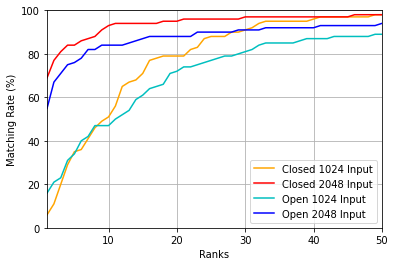

In [45]:
cmc_re_2048 = cmc_re_2048[:50]
cmc_re_1024 = cmc_re_1024[:50]

cmc_re_2048_ = cmc_re_2048_[:50]
cmc_re_1024_ = cmc_re_1024_[:50]

ranks = [a for a in range(1,51)]

plt.plot(ranks, 100*cmc_re_1024, 'orange', label='Closed 1024 Input')
plt.plot(ranks, 100*cmc_re_2048, 'r', label='Closed 2048 Input')
plt.plot(ranks, 100*cmc_re_1024_, 'c', label='Open 1024 Input')
plt.plot(ranks, 100*cmc_re_2048_, 'b', label='Open 2048 Input')
plt.xlabel('Ranks')
plt.ylabel('Matching Rate (%)')
plt.axis([1, 50, 0, 100])
plt.grid()
plt.legend()
plt.show()